In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [31]:
%pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [32]:
%pip install numpy torch matplotlib


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [33]:
%pip install gymnasium[toy_text]

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# import sys
# sys.path.append('/home/jupyter/.local/lib/python3.10/site-packages')

(314, {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)})


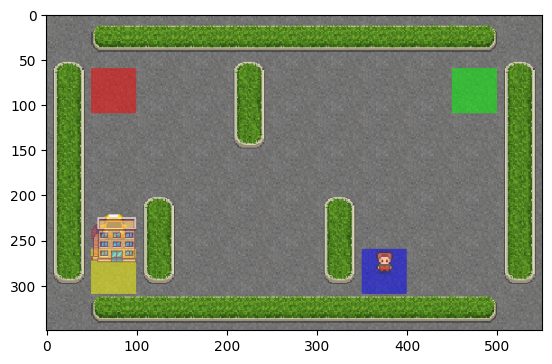

In [35]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch

env = gym.make("Taxi-v3", render_mode="rgb_array")
print(env.reset(seed=0))
plt.imshow(env.render())


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

Using device: cuda


In [37]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"n_states={n_states}, n_actions={n_actions}")


n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize the policy __uniformly__, that is, probabililities of all actions should be equal.

In [ ]:
def initialize_policy(n_states, n_actions):
    policy = np.ones([n_states, n_actions]) / n_actions
    return policy


policy = initialize_policy(n_states, n_actions)


In [ ]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1.0 / n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)


AssertionError: 

# Play the game

Just like before, but we also record all states and actions we took.

In [ ]:
def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.0

    s, _ = env.reset()

    for t in range(t_max):
        # Hint: you can use np.random.choice for sampling action
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

        a = np.random.choice(n_actions, p=policy[s])


        new_s, r, terminated, truncated, _ = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break

    return states, actions, total_reward


In [ ]:
s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float64]


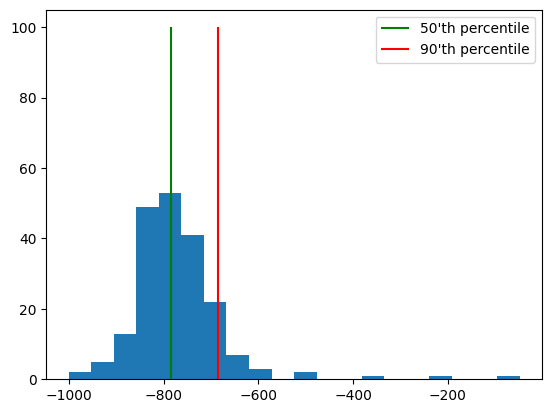

In [41]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Crossentropy method steps

In [42]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, q=percentile)

    elite_states = [] 
    elite_actions = []
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    return elite_states, elite_actions


In [ ]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30
)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90
)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100
)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]
), "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and np.all(
    test_result_30[1] == [3, 2, 0, 1, 3, 3]
), "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and np.all(
    test_result_90[1] == [3, 3]
), "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and np.all(
    test_result_100[1] == [3, 3]
), "Please make sure you use >=, not >. Also double-check how you compute percentile."

print("Ok!")


Ok!


In [ ]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    for s, a in zip(elite_states, elite_actions):
        new_policy[s][a] += 1
    new_policy = new_policy / np.sum(new_policy, axis=1, keepdims=True)
    new_policy[np.isnan(new_policy)] = 1 / n_actions
    # Don't forget to set 1/n_actions for all actions in unvisited states.

    return new_policy


In [ ]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = get_new_policy(elite_states, elite_actions)

assert np.isfinite(
    new_policy
).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0
), "Your new policy can't have negative action probabilities"
assert np.allclose(
    new_policy.sum(axis=-1), 1
), "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.5, 0.0],
        [0.0, 0.33333333, 0.66666667, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.5, 0.5],
    ]
)
assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")


Ok!


/tmp/ipykernel_8361/2515468982.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_policy = new_policy / np.sum(new_policy, axis=1, keepdims=True)


# Training loop
Generate sessions, select N best and fit to those.

In [44]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, experiment_name="", reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.title(f"{experiment_name} - Mean Reward Progress")
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title(f"{experiment_name} - Reward Distribution")
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [threshold],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(True)
    print(f"{experiment_name} - mean reward = {mean_reward:.3f}, threshold = {threshold:.3f}")
    plt.show()


In [45]:
# reset policy just in case
policy = initialize_policy(n_states, n_actions)


In [46]:
n_sessions = 250  # sample this many sessions
percentile = 50  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in range(100):
    %time sessions = [generate_session(env, policy) for _ in range(n_sessions // 2)]
    sessions = [s for s in sessions if s[2] > -1000] + [generate_session(env, policy)] 
    
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)


 - mean reward = -595.444, threshold = -650.000


KeyboardInterrupt: 

### Reflecting on results

You may have noticed that the taxi problem quickly converges from less than -1000 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

In case CEM failed to learn how to win from one distinct starting point, it will simply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or change the way you evaluate strategy (theoretically correct way). For each starting state, you can sample an action randomly, and then evaluate this action by running _several_ games starting from it and averaging the total reward. Choosing elite sessions with this kind of sampling (where each session's reward is counted as the average of the rewards of all sessions with the same starting state and action) should improve the performance of your policy.

# Финишируем работу CEM!

На семинаре мы пришли к тому что у нас средняя награда отрицательная и сильно разнится с порогом, соотвественнон надо думать про то как улучшить процесс игры. В качестве решения я проведу несколько экспериментов и посмотрю на их работу:

1.Обычный метод: стандартный отбор элитных сессий и обновление политики. (он как бы есть, но я хочу все наглядно в одном месте для более простого сравнения глазками)

2.Меньший порог элиты: уменьшаем порог элитных сессий для более разнообразной выборки.

3.Средняя награда для стартовых состояний: используем несколько игр для оценки стартового состояния и действия.

4.Агрессивное обновление политики: увеличиваем learning_rate для более быстрого обновления.

5.Уменьшение случайности (epsilon-greedy): добавляем метод с уменьшением случайности при выборе действия.

И еще мне не нрав, что графики без подписей осей, поэтому я добавлю это! Плюс для реализации моих экспов, я добавлю пару функций

In [78]:
def simulate_single_game(env, state, action):
    total_reward = 0
    s, _ = env.reset()
    terminated, truncated = False, False
    while not (terminated or truncated):
        new_s, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        s = new_s
    return total_reward

In [79]:
# функ ция для оценки действия из заданного состояния проводя несколько игр
def evaluate_state_action_pair(env, state, action, n_trials=10):
    total_reward = 0
    for _ in range(n_trials):
        total_reward += simulate_single_game(env, state, action)
    return total_reward / n_trials

In [80]:
def evaluate_with_multiple_games(env, elite_states, elite_actions, n_trials=5):
    new_elite_states = []
    new_elite_actions = []
    for s, a in zip(elite_states, elite_actions):
        avg_reward = evaluate_state_action_pair(env, s, a, n_trials)
        if avg_reward > -500:  
            new_elite_states.append(s)
            new_elite_actions.append(a)
    return new_elite_states, new_elite_actions

### Эксперимент 1: Стандартный метод обновления политики


In [81]:
def experiment_1(env, n_sessions, percentile, learning_rate=0.5, epsilon=0.1):
    log = []
    policy = initialize_policy(n_states, n_actions)

    for i in range(100):
        sessions = [generate_session(env, policy) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
        new_policy = get_new_policy(elite_states, elite_actions)
        
        policy = learning_rate * new_policy + (1 - learning_rate) * policy

        show_progress(rewards_batch, log, percentile)
    return log

###  Эксперимент 2: Оценка через несколько игр для уменьшения случайности


In [82]:
def experiment_2(env, n_sessions, percentile, learning_rate=0.5, epsilon=0.1):
    log = []
    policy = initialize_policy(n_states, n_actions)

    for i in range(100):
        sessions = [generate_session(env, policy) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
        # юзаем несколько игр для оценки стартового состояния
        elite_states, elite_actions = evaluate_with_multiple_games(env, elite_states, elite_actions)

        new_policy = get_new_policy(elite_states, elite_actions)
        
        # обновляю политику с более высоким learning_rate
        policy = 0.8 * new_policy + 0.2 * policy

        show_progress(rewards_batch, log, percentile)
    return log


### Эксперимент 3: Снижение порога элитных сессий и применение epsilon-greedy (смешение с uniform распределением)


In [83]:
def experiment_3(env, n_sessions, percentile, learning_rate=0.5, epsilon=0.1, experiment_name="Experiment 3: Lower Elite Threshold & Epsilon-Greedy"):
    log = []
    policy = initialize_policy(n_states, n_actions)

    for i in range(100):
        sessions = [generate_session(env, policy) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)

        # Используем более низкий порог для отбора элиты
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)

        new_policy = get_new_policy(elite_states, elite_actions)
        
        # Смешиваем с равномерным распределением для epsilon-greedy
        uniform_policy = np.ones([n_states, n_actions]) / n_actions
        new_policy = (1 - epsilon) * new_policy + epsilon * uniform_policy

        policy = learning_rate * new_policy + (1 - learning_rate) * policy

        show_progress(rewards_batch, log, percentile, experiment_name)
    return log


### Эксперимент 4: Комбинированный метод с агрессивным обновлением политики (так сказать терять нечего)


In [84]:
def experiment_4(env, n_sessions, percentile, learning_rate=0.5, epsilon=0.05, experiment_name="Experiment 4: Combined Methods with Aggressive Update"):
    log = []
    policy = initialize_policy(n_states, n_actions)

    for i in range(100):
        sessions = [generate_session(env, policy) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)

        # Комбинированный отбор элитных сессий: низкий порог и мультиоценка
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
        elite_states, elite_actions = evaluate_with_multiple_games(env, elite_states, elite_actions)

        new_policy = get_new_policy(elite_states, elite_actions)
        
        policy = 0.9 * new_policy + 0.1 * policy

        show_progress(rewards_batch, log, percentile, experiment_name)
    return log

In [85]:
n_sessions = 250
percentile = 50
learning_rate = 0.5
epsilon = 0.1

## Standard Method

 - mean reward = -87.400, threshold = 6.500


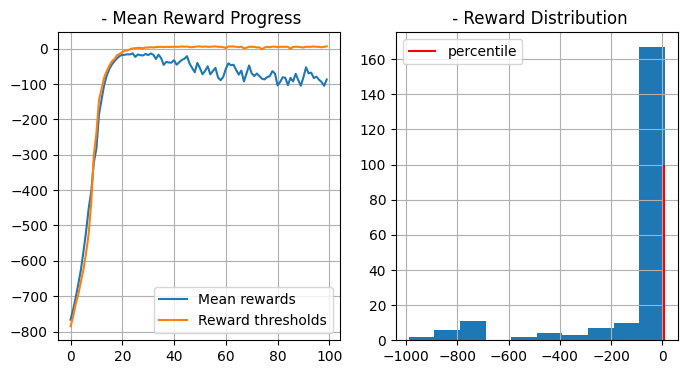

In [86]:
log_1 = experiment_1(env, n_sessions, percentile, learning_rate, epsilon)

## Multi-Game Evaluation

 - mean reward = -201.080, threshold = -200.000


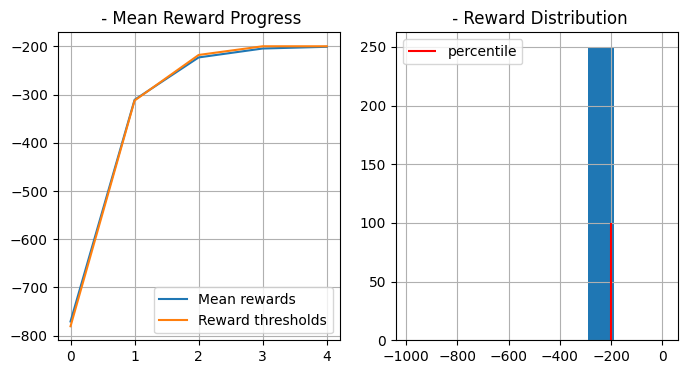

KeyboardInterrupt: 

In [87]:
log_2 = experiment_2(env, n_sessions, percentile, learning_rate, epsilon)

## Lower Elite Threshold & Epsilon-Greedy

In [ ]:
log_3 = experiment_3(env, n_sessions, percentile, learning_rate, epsilon)


Experiment 3: Lower Elite Threshold & Epsilon-Greedy - mean reward = -695.880, threshold = -713.000


KeyboardInterrupt: 

## Combined Methods with Aggressive Update

In [ ]:
log_4 = experiment_4(env, n_sessions, percentile, learning_rate, epsilon=0.05)


### You're not done yet!

Go to [`./deep_crossentropy_method.ipynb`](./deep_crossentropy_method.ipynb) for a more serious task